In [63]:
from music21 import corpus, stream, note
import tensorflow as tf
import math
import functools
import numpy as np
import random

In [2]:
# numbeer of voices
num_voices = 4

#number of output classes, i.e. half tone differences to melody
num_classes = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
time_tick = 0.25

In [3]:
def extractMelody(music):
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += time_tick;
        noteTicks = math.floor(n.duration.quarterLength / time_tick)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += time_tick;
    return melody

In [4]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to num_classes. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    # -1 for adding 1 below, additionl -1 so that diff can be index 
    while (diff > num_classes - 2):
        diff -= 12
    return diff + 1

In [5]:
def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

In [6]:
songs = []
streams = []
for name in corpus.chorales.Iterator(returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and song.parts[0].flat.getTimeSignatures()[0].numerator == 4 and key.mode == 'major' \
        and highestTime < 68:
        print('%s: %s, %s voices, duration: %s' % (name, key, len(song.parts), highestTime))
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

bach/bwv86.6: E major, 4 voices, duration: 56.0
bach/bwv281: F major, 4 voices, duration: 32.0
bach/bwv248.12-2: G major, 4 voices, duration: 64.0
bach/bwv318: G major, 4 voices, duration: 52.0
bach/bwv415: D major, 4 voices, duration: 64.0
bach/bwv20.11: F major, 4 voices, duration: 64.0
bach/bwv308: B- major, 4 voices, duration: 56.0
bach/bwv386: A major, 4 voices, duration: 65.0
bach/bwv248.53-5: A major, 4 voices, duration: 48.0
bach/bwv385: A major, 4 voices, duration: 56.0
bach/bwv255: G major, 4 voices, duration: 32.0
bach/bwv67.7: A major, 4 voices, duration: 52.0
bach/bwv377: D major, 4 voices, duration: 48.0
'Chord' object has no attribute 'pitch'
Error: bach/bwv377 not expected format, ignored
bach/bwv244.37: F major, 4 voices, duration: 48.0
Error: voice above melody
Error: bach/bwv244.37 not expected format, ignored
bach/bwv429: A major, 4 voices, duration: 60.0
bach/bwv151.5: G major, 4 voices, duration: 40.0
bach/bwv133.6: D major, 4 voices, duration: 64.0
bach/bwv159.5:

In [7]:
print(len(songs))

98


In [8]:
def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            attackIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[attackIndex] == 0:
                notes[voice].quarterLength += time_tick
            
            if tick[attackIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[melodyPitchIndex] - tick[pitchIndex] + 1
                    n.quarterLength = time_tick
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = time_tick
                    part.append(n)
    return sc
    
                        

In [67]:
# https://gist.github.com/danijar/61f9226f7ea498abce36187ddaf51ed5
# Example for my blog post at:
# http://danijar.com/introduction-to-recurrent-networks-in-tensorflow/
import functools
import tensorflow as tf

# for state_is_tuple = True, currently does not work with undefined batch size
def get_state_variables(batch_size, cell):
    # For each layer, get the initial state and make a variable out of it
    # to enable updating its value.
    state_variables = []
    for state_c, state_h in cell.zero_state(batch_size, tf.float32):
        state_variables.append(tf.contrib.rnn.LSTMStateTuple(
            tf.Variable(state_c, trainable=False),
            tf.Variable(state_h, trainable=False)))
    # Return as a tuple, so that it can be fed to dynamic_rnn as an initial state
    return tuple(state_variables)


def get_state_update_op(state_variables, new_states):
    # Add an operation to update the train states with the last state tensors
    update_ops = []
    for state_variable, new_state in zip(state_variables, new_states):
        # Assign the new state to the state variables on this layer
        update_ops.extend([state_variable[0].assign(new_state[0]),
                           state_variable[1].assign(new_state[1])])
    # Return a tuple in order to combine all update_ops into a single operation.
    # The tuple's actual value should not be used.
    return tf.tuple(update_ops)

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class SequenceLabelling:

    def __init__(self, data, seq_length, target, dropout, num_hidden=200, num_layers=1, num_voices = 4):
        self.data = data
        self.target = target
        self.dropout = dropout
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.prediction
        self.error
        self.optimize
        #self.update_states

    @lazy_property
    def prediction(self):
        # Recurrent network.
        #cells = [tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)] * self._num_hidden
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            # a lot of fluctuation (8th/16th) in the results between different possible notes.
            # this might be reduced by the peep holes?
            cells.append(tf.nn.rnn_cell.LSTMCell(self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = TRue, does not work with undefined btch size
        #self.states = get_state_variables(data.shape[0], network)
        #state = tf.Variable(network.zero_states(data.shape[0], tf.float32), trainable=False)
        
        output, new_states = tf.nn.dynamic_rnn(network, data, dtype=tf.float32, 
                                               sequence_length=self.seq_length) #, initial_state=states)
        
        # Add an operation to update the train states with the last state tensors.
        # if state_is_tuple = True, does not work with undefined btch size
        # self.update_states = get_state_update_op(states, new_states)
        # self.update_states = states.assign(new_states)
        
        # Softmax layer.
        max_length = int(self.target.get_shape()[1])
        num_classes = int(self.target.get_shape()[3])
        weight, bias = self._weight_and_bias(self._num_hidden, num_classes * (num_voices - 1))
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction = tf.matmul(output, weight) + bias
        prediction = tf.nn.softmax(tf.reshape(prediction, [-1, max_length, (num_voices - 1), num_classes]))
        return prediction

    @lazy_property
    def cost(self):
        masking = True
        if (masking):
            # Compute cross entropy for each frame.
            cross_entropy = target * tf.log(self.prediction)
            cross_entropy = -tf.reduce_sum(cross_entropy, [2, 3])
            # mask out padding. ToDo: also rests have target value of 0
            mask = tf.sign(tf.reduce_max(tf.abs(target), [2, 3]))
            cross_entropy *= mask
            # Average over actual sequence lengths.
            cross_entropy = tf.reduce_sum(cross_entropy, 1)
            cross_entropy /= tf.reduce_sum(mask, 1)
            return tf.reduce_mean(cross_entropy)        
        else:
            # without masking:
            cross_entropy = -tf.reduce_sum(
            self.target * tf.log(self.prediction), [1, 2, 3])
            cross_entropy = tf.reduce_mean(cross_entropy)
            return cross_entropy

    @lazy_property
    def optimize(self):
        learning_rate = 0.003
        #optimizer = tf.train.RMSPropOptimizer(learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 3), tf.argmax(self.prediction, 3))
        mistakes = tf.cast(mistakes, tf.float32)
        # mask out padding. ToDo: also rests have target value of 0
        mask = tf.sign(tf.reduce_max(tf.abs(target), 3))
        mistakes *= mask
        return tf.reduce_mean(tf.cast(mistakes, tf.float32))

    @staticmethod
    def _weight_and_bias(in_size, out_size):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight), tf.Variable(bias)


def read_dataset(songs, num_voices = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print(max_seq_length)
    
    m = len(songs)    
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            x.append([tick[1], tick[2]])
            
            voices = []
            for voice in range(num_voices - 1):
                oneHot = np.zeros(num_classes)
                #print(tick)
                oneHot[tick[3 + voice * 2]] = 1
                #print(oneHot)
                voices.append(oneHot)
            y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0, 0])
            voices = []
            for voice in range(num_voices - 1):
                voices.append(np.zeros(num_classes))
            y.append(voices)
        X.append(x)
        Y.append(y)   
    #print(Y[0])
    target = np.array(Y)
    print(target.shape)
    dataset = {'data': np.array(X), 'target' : np.array(Y), 'seq_length' : np.array(seq_length)}
    train, test = dataset, dataset#sets.Split(0.66)(dataset)
    return train, test


if __name__ == '__main__':
    tf.reset_default_graph()
    train, test = read_dataset(songs)
    print(train['data'].shape)
    print(train['target'].shape)
    _, length, input_size = train['data'].shape
    num_classes = train['target'].shape[3]
    data = tf.placeholder(tf.float32, [None, length, input_size])
    target = tf.placeholder(tf.float32, [None, length, num_voices - 1, num_classes])
    seq_length = tf.placeholder(tf.float32, [None])
    dropout = tf.placeholder(tf.float32)
    model = SequenceLabelling(data, seq_length, target, dropout, num_hidden = 500, num_layers=3)
    sess = tf.Session()
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())

256
(98, 256, 3, 26)
(98, 256, 2)
(98, 256, 3, 26)


In [68]:
    random.seed(42)
    for epoch in range(5000):
        batchsize = random.randint(8, 12)
        for batchnum in range(math.floor(90 / batchsize)):
            batch_start = batchnum * batchsize
            batch_end = batchnum * batchsize + batchsize
            batch_end = min(90, batch_end)
            batch_data = train['data'][batch_start : batch_end]
            batch_target = train['target'][batch_start : batch_end]
            batch_seq_length = train['seq_length'][batch_start : batch_end]
            #batch = train #.sample(10)
            sess.run(model.optimize, {
                data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 0.5})
            error_batch = sess.run(model.error, {
                data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 1})
            print('   Batch {:2d} {:2d}-{:2d} error {:3.1f}%'.format(batchnum + 1, batch_start, batch_end, 100 * error_batch))
        error = sess.run(model.error, {
            data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
        prediction = sess.run(model.prediction, {
            data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
        for i in range(10): #test['seq_length'][0]):
            targ = np.argmax(test['target'][0, i, 0])
            pred = np.argmax(prediction[0, i, 0])
            print("%s (%s) - %s (%s)" % (targ, prediction[0, i, 0, targ], pred, prediction[0, i, 0, pred]))
            #print(batch['target'][0][0])
        print('Epoch {:2d} error {:3.1f}% --------------------------------'.format(epoch + 1, 100 * error))
            

   Batch  1  0- 8 error 70.5%
   Batch  2  8-16 error 65.4%
   Batch  3 16-24 error 65.5%
   Batch  4 24-32 error 72.2%
   Batch  5 32-40 error 61.0%
   Batch  6 40-48 error 67.7%
   Batch  7 48-56 error 58.3%
   Batch  8 56-64 error 60.0%
   Batch  9 64-72 error 72.6%
   Batch 10 72-80 error 64.5%
   Batch 11 80-88 error 71.4%
4 (0.1421) - 6 (0.180656)
4 (0.16108) - 6 (0.219825)
4 (0.163235) - 6 (0.224216)
4 (0.163583) - 6 (0.224712)
6 (0.224673) - 6 (0.224673)
6 (0.224568) - 6 (0.224568)
4 (0.163736) - 6 (0.224458)
4 (0.163762) - 6 (0.22435)
3 (0.0491986) - 6 (0.224246)
3 (0.0492177) - 6 (0.224145)
Epoch  1 error 66.6% --------------------------------
   Batch  1  0- 8 error 72.0%
   Batch  2  8-16 error 64.3%
   Batch  3 16-24 error 65.2%
   Batch  4 24-32 error 71.8%
   Batch  5 32-40 error 61.0%
   Batch  6 40-48 error 68.1%
   Batch  7 48-56 error 59.0%
   Batch  8 56-64 error 59.0%
   Batch  9 64-72 error 72.6%
   Batch 10 72-80 error 64.5%
   Batch 11 80-88 error 71.4%
4 (0.149

   Batch  3 16-24 error 63.6%
   Batch  4 24-32 error 72.5%
   Batch  5 32-40 error 62.5%
   Batch  6 40-48 error 66.0%
   Batch  7 48-56 error 55.6%
   Batch  8 56-64 error 57.6%
   Batch  9 64-72 error 70.5%
   Batch 10 72-80 error 64.3%
   Batch 11 80-88 error 71.0%
4 (0.157813) - 6 (0.349168)
4 (0.171988) - 6 (0.369966)
4 (0.178282) - 6 (0.352751)
4 (0.180775) - 6 (0.339926)
6 (0.323575) - 6 (0.323575)
6 (0.303044) - 6 (0.303044)
4 (0.185083) - 6 (0.286226)
4 (0.185257) - 6 (0.27506)
3 (0.0341796) - 6 (0.266444)
3 (0.0350392) - 6 (0.258512)
Epoch 14 error 65.6% --------------------------------
   Batch  1  0- 9 error 67.5%
   Batch  2  9-18 error 64.5%
   Batch  3 18-27 error 66.1%
   Batch  4 27-36 error 66.9%
   Batch  5 36-45 error 64.5%
   Batch  6 45-54 error 58.0%
   Batch  7 54-63 error 59.1%
   Batch  8 63-72 error 67.8%
   Batch  9 72-81 error 65.1%
   Batch 10 81-90 error 70.6%
4 (0.147236) - 6 (0.370388)
4 (0.156347) - 6 (0.399937)
4 (0.162388) - 6 (0.381231)
4 (0.166878

   Batch  1  0- 8 error 67.9%
   Batch  2  8-16 error 62.5%
   Batch  3 16-24 error 63.1%
   Batch  4 24-32 error 71.0%
   Batch  5 32-40 error 61.7%
   Batch  6 40-48 error 65.3%
   Batch  7 48-56 error 55.1%
   Batch  8 56-64 error 57.2%
   Batch  9 64-72 error 70.4%
   Batch 10 72-80 error 64.1%
   Batch 11 80-88 error 70.1%
4 (0.132374) - 6 (0.509107)
4 (0.137499) - 6 (0.52311)
4 (0.148231) - 6 (0.474443)
4 (0.158413) - 6 (0.431285)
6 (0.322613) - 6 (0.322613)
6 (0.257256) - 6 (0.257256)
4 (0.194756) - 6 (0.236514)
4 (0.195193) - 6 (0.22762)
3 (0.0413268) - 6 (0.220517)
3 (0.0426289) - 6 (0.21515)
Epoch 28 error 64.9% --------------------------------
   Batch  1  0- 9 error 66.6%
   Batch  2  9-18 error 64.0%
   Batch  3 18-27 error 65.6%
   Batch  4 27-36 error 64.9%
   Batch  5 36-45 error 62.9%
   Batch  6 45-54 error 55.9%
   Batch  7 54-63 error 59.8%
   Batch  8 63-72 error 67.8%
   Batch  9 72-81 error 64.9%
   Batch 10 81-90 error 70.4%
4 (0.141298) - 6 (0.503907)
4 (0.1491

   Batch  4 30-40 error 60.2%
   Batch  5 40-50 error 59.6%
   Batch  6 50-60 error 59.1%
   Batch  7 60-70 error 64.2%
   Batch  8 70-80 error 65.2%
   Batch  9 80-90 error 68.7%
4 (0.129142) - 6 (0.54654)
4 (0.121912) - 6 (0.569545)
4 (0.13788) - 6 (0.508902)
4 (0.14712) - 6 (0.476344)
6 (0.305509) - 6 (0.305509)
6 (0.265073) - 6 (0.265073)
4 (0.196073) - 6 (0.255194)
4 (0.195554) - 6 (0.251559)
3 (0.0420129) - 6 (0.24862)
3 (0.0444016) - 6 (0.243757)
Epoch 41 error 64.3% --------------------------------
   Batch  1  0-12 error 63.2%
   Batch  2 12-24 error 64.9%
   Batch  3 24-36 error 68.1%
   Batch  4 36-48 error 63.4%
   Batch  5 48-60 error 55.5%
   Batch  6 60-72 error 65.3%
   Batch  7 72-84 error 64.2%
4 (0.15177) - 6 (0.505613)
4 (0.148627) - 6 (0.518163)
4 (0.167468) - 6 (0.455903)
4 (0.179343) - 6 (0.418293)
6 (0.255896) - 6 (0.255896)
6 (0.222658) - 4 (0.231384)
4 (0.230192) - 4 (0.230192)
4 (0.228434) - 4 (0.228434)
3 (0.0375948) - 4 (0.226092)
3 (0.0398736) - 4 (0.22152

   Batch  2  9-18 error 63.4%
   Batch  3 18-27 error 65.0%
   Batch  4 27-36 error 65.2%
   Batch  5 36-45 error 62.3%
   Batch  6 45-54 error 55.7%
   Batch  7 54-63 error 58.6%
   Batch  8 63-72 error 67.1%
   Batch  9 72-81 error 64.1%
   Batch 10 81-90 error 68.3%
4 (0.138651) - 6 (0.522713)
4 (0.131179) - 6 (0.527937)
4 (0.138313) - 6 (0.492344)
4 (0.144683) - 6 (0.468538)
6 (0.264296) - 6 (0.264296)
6 (0.22228) - 6 (0.22228)
4 (0.207625) - 6 (0.210532)
4 (0.203987) - 6 (0.20597)
3 (0.0471348) - 6 (0.203088)
3 (0.0501336) - 6 (0.199361)
Epoch 55 error 64.1% --------------------------------
   Batch  1  0- 8 error 67.0%
   Batch  2  8-16 error 61.8%
   Batch  3 16-24 error 62.4%
   Batch  4 24-32 error 69.6%
   Batch  5 32-40 error 60.7%
   Batch  6 40-48 error 64.8%
   Batch  7 48-56 error 54.8%
   Batch  8 56-64 error 57.2%
   Batch  9 64-72 error 69.8%
   Batch 10 72-80 error 63.9%
   Batch 11 80-88 error 69.9%
4 (0.145267) - 6 (0.526753)
4 (0.137352) - 6 (0.541464)
4 (0.14544)

   Batch  4 30-40 error 59.1%
   Batch  5 40-50 error 60.7%
   Batch  6 50-60 error 58.0%
   Batch  7 60-70 error 63.3%
   Batch  8 70-80 error 64.9%
   Batch  9 80-90 error 69.4%
4 (0.148446) - 6 (0.536397)
4 (0.130147) - 6 (0.558223)
4 (0.131702) - 6 (0.536758)
4 (0.140814) - 6 (0.508668)
6 (0.297737) - 6 (0.297737)
6 (0.257452) - 6 (0.257452)
4 (0.220383) - 6 (0.239606)
4 (0.21208) - 6 (0.224955)
3 (0.0516796) - 6 (0.214311)
3 (0.0545258) - 6 (0.210676)
Epoch 68 error 63.9% --------------------------------
   Batch  1  0-10 error 65.2%
   Batch  2 10-20 error 59.3%
   Batch  3 20-30 error 71.9%
   Batch  4 30-40 error 59.6%
   Batch  5 40-50 error 59.4%
   Batch  6 50-60 error 59.2%
   Batch  7 60-70 error 64.2%
   Batch  8 70-80 error 65.1%
   Batch  9 80-90 error 70.7%
4 (0.161632) - 6 (0.445076)
4 (0.146798) - 6 (0.430492)
4 (0.142547) - 6 (0.401643)
4 (0.148519) - 6 (0.368105)
6 (0.18848) - 8 (0.215652)
6 (0.149157) - 8 (0.221128)
4 (0.181863) - 8 (0.220994)
4 (0.170805) - 8 (0.

   Batch  1  0- 9 error 64.5%
   Batch  2  9-18 error 62.2%
   Batch  3 18-27 error 63.5%
   Batch  4 27-36 error 63.6%
   Batch  5 36-45 error 60.0%
   Batch  6 45-54 error 53.8%
   Batch  7 54-63 error 57.8%
   Batch  8 63-72 error 66.1%
   Batch  9 72-81 error 62.1%
   Batch 10 81-90 error 68.1%
4 (0.12877) - 6 (0.509391)
4 (0.104209) - 6 (0.518629)
4 (0.0955524) - 6 (0.470966)
4 (0.0990826) - 6 (0.372987)
6 (0.204203) - 8 (0.251621)
6 (0.158327) - 8 (0.257849)
4 (0.106807) - 8 (0.256259)
4 (0.101121) - 8 (0.248482)
3 (0.0382156) - 8 (0.237244)
3 (0.0356317) - 8 (0.225282)
Epoch 82 error 62.7% --------------------------------
   Batch  1  0-10 error 64.1%
   Batch  2 10-20 error 59.3%
   Batch  3 20-30 error 69.1%
   Batch  4 30-40 error 61.0%
   Batch  5 40-50 error 60.6%
   Batch  6 50-60 error 56.3%
   Batch  7 60-70 error 62.9%
   Batch  8 70-80 error 63.0%
   Batch  9 80-90 error 66.4%
4 (0.140475) - 6 (0.527777)
4 (0.118228) - 6 (0.551795)
4 (0.106687) - 6 (0.499364)
4 (0.1117

   Batch  5 44-55 error 54.6%
   Batch  6 55-66 error 55.1%
   Batch  7 66-77 error 61.6%
   Batch  8 77-88 error 65.9%
4 (0.13835) - 6 (0.528585)
4 (0.109675) - 6 (0.528928)
4 (0.0849314) - 6 (0.438132)
4 (0.093017) - 6 (0.329619)
6 (0.215027) - 8 (0.252601)
6 (0.192904) - 8 (0.264454)
4 (0.0982657) - 8 (0.270383)
4 (0.0919728) - 8 (0.268199)
3 (0.0200752) - 8 (0.26095)
3 (0.0195211) - 8 (0.255122)
Epoch 95 error 61.3% --------------------------------
   Batch  1  0-11 error 61.6%
   Batch  2 11-22 error 59.7%
   Batch  3 22-33 error 67.2%
   Batch  4 33-44 error 59.7%
   Batch  5 44-55 error 54.1%
   Batch  6 55-66 error 55.4%
   Batch  7 66-77 error 61.6%
   Batch  8 77-88 error 65.9%
4 (0.138936) - 6 (0.538072)
4 (0.0953306) - 6 (0.581126)
4 (0.0807111) - 6 (0.450677)
4 (0.0842651) - 6 (0.351909)
6 (0.224256) - 8 (0.271499)
6 (0.185958) - 8 (0.281359)
4 (0.089999) - 8 (0.28464)
4 (0.0881292) - 8 (0.278434)
3 (0.0208151) - 8 (0.272614)
3 (0.0199968) - 8 (0.267502)
Epoch 96 error 60.

   Batch  5 40-50 error 57.0%
   Batch  6 50-60 error 52.1%
   Batch  7 60-70 error 59.4%
   Batch  8 70-80 error 60.7%
   Batch  9 80-90 error 64.7%
4 (0.147453) - 6 (0.541298)
4 (0.117547) - 6 (0.532304)
4 (0.0792303) - 6 (0.382371)
4 (0.0779687) - 6 (0.341267)
6 (0.24604) - 8 (0.266741)
6 (0.216629) - 8 (0.276283)
4 (0.103446) - 8 (0.285839)
4 (0.0866838) - 8 (0.28973)
3 (0.0171457) - 8 (0.284752)
3 (0.0161019) - 8 (0.280629)
Epoch 109 error 59.0% --------------------------------
   Batch  1  0- 9 error 61.8%
   Batch  2  9-18 error 58.8%
   Batch  3 18-27 error 61.5%
   Batch  4 27-36 error 58.7%
   Batch  5 36-45 error 60.2%
   Batch  6 45-54 error 51.0%
   Batch  7 54-63 error 54.5%
   Batch  8 63-72 error 63.4%
   Batch  9 72-81 error 59.1%
   Batch 10 81-90 error 65.6%
4 (0.153004) - 6 (0.523772)
4 (0.129132) - 6 (0.513051)
4 (0.0816024) - 6 (0.383411)
4 (0.0792218) - 6 (0.33655)
6 (0.250301) - 8 (0.275967)
6 (0.24074) - 8 (0.26761)
4 (0.148885) - 8 (0.256945)
4 (0.116707) - 8 

   Batch  1  0-11 error 60.5%
   Batch  2 11-22 error 58.6%
   Batch  3 22-33 error 64.9%
   Batch  4 33-44 error 57.5%
   Batch  5 44-55 error 51.9%
   Batch  6 55-66 error 53.3%
   Batch  7 66-77 error 59.1%
   Batch  8 77-88 error 65.9%
4 (0.146741) - 6 (0.53966)
4 (0.110179) - 6 (0.566493)
4 (0.0794174) - 6 (0.389336)
4 (0.0786368) - 6 (0.356212)
6 (0.284078) - 6 (0.284078)
6 (0.244839) - 8 (0.256907)
4 (0.10294) - 8 (0.278613)
4 (0.0937751) - 8 (0.289581)
3 (0.0199229) - 8 (0.288992)
3 (0.0191411) - 8 (0.286594)
Epoch 123 error 59.9% --------------------------------
   Batch  1  0-12 error 58.5%
   Batch  2 12-24 error 59.2%
   Batch  3 24-36 error 60.0%
   Batch  4 36-48 error 58.5%
   Batch  5 48-60 error 49.8%
   Batch  6 60-72 error 60.6%
   Batch  7 72-84 error 60.2%
4 (0.145166) - 6 (0.556996)
4 (0.112523) - 6 (0.583984)
4 (0.081962) - 6 (0.416092)
4 (0.0792) - 6 (0.384023)
6 (0.32938) - 6 (0.32938)
6 (0.277055) - 6 (0.277055)
4 (0.158589) - 6 (0.246749)
4 (0.154463) - 8 (0.

   Batch  1  0- 9 error 60.8%
   Batch  2  9-18 error 58.9%
   Batch  3 18-27 error 60.4%
   Batch  4 27-36 error 58.1%
   Batch  5 36-45 error 57.7%
   Batch  6 45-54 error 50.3%
   Batch  7 54-63 error 52.9%
   Batch  8 63-72 error 61.5%
   Batch  9 72-81 error 58.1%
   Batch 10 81-90 error 66.8%
4 (0.136687) - 6 (0.573867)
4 (0.130557) - 6 (0.561764)
4 (0.0778591) - 6 (0.368031)
4 (0.0801023) - 6 (0.310815)
6 (0.313266) - 6 (0.313266)
6 (0.288652) - 6 (0.288652)
4 (0.118522) - 6 (0.266647)
4 (0.100307) - 8 (0.286441)
3 (0.0310237) - 8 (0.29028)
3 (0.033265) - 8 (0.286364)
Epoch 137 error 58.7% --------------------------------
   Batch  1  0-11 error 58.8%
   Batch  2 11-22 error 56.0%
   Batch  3 22-33 error 63.4%
   Batch  4 33-44 error 55.6%
   Batch  5 44-55 error 52.2%
   Batch  6 55-66 error 53.0%
   Batch  7 66-77 error 59.6%
   Batch  8 77-88 error 64.5%
4 (0.139227) - 6 (0.5317)
4 (0.132415) - 6 (0.501329)
4 (0.0738532) - 6 (0.296679)
4 (0.0779285) - 8 (0.300152)
6 (0.248033

   Batch  1  0- 9 error 60.5%
   Batch  2  9-18 error 59.4%
   Batch  3 18-27 error 59.4%
   Batch  4 27-36 error 57.2%
   Batch  5 36-45 error 58.5%
   Batch  6 45-54 error 51.7%
   Batch  7 54-63 error 52.9%
   Batch  8 63-72 error 60.2%
   Batch  9 72-81 error 58.7%
   Batch 10 81-90 error 66.8%
4 (0.132382) - 6 (0.586037)
4 (0.129672) - 6 (0.568434)
4 (0.0906262) - 6 (0.328698)
4 (0.0888484) - 6 (0.296938)
6 (0.326981) - 6 (0.326981)
6 (0.29603) - 6 (0.29603)
4 (0.165447) - 6 (0.273799)
4 (0.173254) - 6 (0.236665)
3 (0.0678088) - 8 (0.243041)
3 (0.0756061) - 8 (0.242921)
Epoch 151 error 59.5% --------------------------------
   Batch  1  0-12 error 57.4%
   Batch  2 12-24 error 58.5%
   Batch  3 24-36 error 58.6%
   Batch  4 36-48 error 57.2%
   Batch  5 48-60 error 49.8%
   Batch  6 60-72 error 58.3%
   Batch  7 72-84 error 59.2%
4 (0.127784) - 6 (0.556174)
4 (0.123761) - 6 (0.538291)
4 (0.079626) - 8 (0.291045)
4 (0.0771381) - 8 (0.32085)
6 (0.286893) - 6 (0.286893)
6 (0.276925) 

   Batch  9 72-81 error 57.4%
   Batch 10 81-90 error 66.1%
4 (0.141071) - 6 (0.581015)
4 (0.132396) - 6 (0.589281)
4 (0.0847055) - 6 (0.327113)
4 (0.0797963) - 6 (0.293931)
6 (0.33322) - 6 (0.33322)
6 (0.328984) - 6 (0.328984)
4 (0.19513) - 6 (0.251902)
4 (0.214177) - 4 (0.214177)
3 (0.129922) - 4 (0.235088)
3 (0.109191) - 4 (0.250726)
Epoch 164 error 58.6% --------------------------------
   Batch  1  0-12 error 57.8%
   Batch  2 12-24 error 59.7%
   Batch  3 24-36 error 59.6%
   Batch  4 36-48 error 57.3%
   Batch  5 48-60 error 49.6%
   Batch  6 60-72 error 60.8%
   Batch  7 72-84 error 59.3%
4 (0.125649) - 6 (0.532916)
4 (0.116206) - 6 (0.540908)
4 (0.0649755) - 8 (0.301765)
4 (0.0608928) - 8 (0.324732)
6 (0.259355) - 6 (0.259355)
6 (0.282398) - 6 (0.282398)
4 (0.0454448) - 8 (0.292585)
4 (0.0456687) - 8 (0.303996)
3 (0.0112739) - 8 (0.302304)
3 (0.0132148) - 8 (0.303242)
Epoch 165 error 58.6% --------------------------------
   Batch  1  0- 8 error 60.2%
   Batch  2  8-16 error 5

   Batch  1  0-12 error 56.5%
   Batch  2 12-24 error 57.7%
   Batch  3 24-36 error 57.2%
   Batch  4 36-48 error 56.0%
   Batch  5 48-60 error 47.5%
   Batch  6 60-72 error 55.7%
   Batch  7 72-84 error 57.5%
4 (0.14239) - 6 (0.553879)
4 (0.135529) - 6 (0.555574)
4 (0.0786401) - 6 (0.309283)
4 (0.0745099) - 8 (0.332711)
6 (0.297801) - 6 (0.297801)
6 (0.343555) - 6 (0.343555)
4 (0.0989266) - 6 (0.317888)
4 (0.0993605) - 8 (0.301019)
3 (0.0217163) - 8 (0.322294)
3 (0.0325015) - 8 (0.333912)
Epoch 178 error 55.8% --------------------------------
   Batch  1  0-11 error 56.9%
   Batch  2 11-22 error 53.8%
   Batch  3 22-33 error 60.0%
   Batch  4 33-44 error 54.4%
   Batch  5 44-55 error 49.0%
   Batch  6 55-66 error 50.3%
   Batch  7 66-77 error 56.7%
   Batch  8 77-88 error 62.5%
4 (0.146903) - 6 (0.515068)
4 (0.14341) - 6 (0.510879)
4 (0.0862367) - 8 (0.281036)
4 (0.0813782) - 8 (0.316983)
6 (0.215745) - 8 (0.239261)
6 (0.304451) - 6 (0.304451)
4 (0.11727) - 8 (0.280604)
4 (0.105336) -

   Batch  1  0- 8 error 59.5%
   Batch  2  8-16 error 53.6%
   Batch  3 16-24 error 52.8%
   Batch  4 24-32 error 58.6%
   Batch  5 32-40 error 51.4%
   Batch  6 40-48 error 56.6%
   Batch  7 48-56 error 45.8%
   Batch  8 56-64 error 48.9%
   Batch  9 64-72 error 58.4%
   Batch 10 72-80 error 54.7%
   Batch 11 80-88 error 62.6%
4 (0.123692) - 6 (0.540552)
4 (0.119603) - 6 (0.525145)
4 (0.0707038) - 5 (0.277077)
4 (0.0653735) - 5 (0.296347)
6 (0.254539) - 5 (0.262353)
6 (0.310833) - 6 (0.310833)
4 (0.14148) - 6 (0.272729)
4 (0.141308) - 8 (0.22166)
3 (0.0841482) - 5 (0.216907)
3 (0.110569) - 5 (0.21084)
Epoch 192 error 56.1% --------------------------------
   Batch  1  0-10 error 57.7%
   Batch  2 10-20 error 50.1%
   Batch  3 20-30 error 59.5%
   Batch  4 30-40 error 51.9%
   Batch  5 40-50 error 53.0%
   Batch  6 50-60 error 48.5%
   Batch  7 60-70 error 53.7%
   Batch  8 70-80 error 57.4%
   Batch  9 80-90 error 64.2%
4 (0.136211) - 6 (0.513848)
4 (0.127811) - 6 (0.501499)
4 (0.0734

   Batch  3 16-24 error 51.5%
   Batch  4 24-32 error 58.0%
   Batch  5 32-40 error 50.9%
   Batch  6 40-48 error 54.8%
   Batch  7 48-56 error 44.7%
   Batch  8 56-64 error 48.6%
   Batch  9 64-72 error 58.2%
   Batch 10 72-80 error 53.7%
   Batch 11 80-88 error 64.3%
4 (0.131325) - 6 (0.52304)
4 (0.12071) - 6 (0.526426)
4 (0.066818) - 8 (0.271707)
4 (0.0613625) - 8 (0.294451)
6 (0.245387) - 5 (0.253624)
6 (0.316679) - 6 (0.316679)
4 (0.0586544) - 8 (0.307553)
4 (0.0552514) - 8 (0.308939)
3 (0.0160009) - 8 (0.301598)
3 (0.0217397) - 8 (0.308633)
Epoch 205 error 55.2% --------------------------------
   Batch  1  0-10 error 57.8%
   Batch  2 10-20 error 49.8%
   Batch  3 20-30 error 60.0%
   Batch  4 30-40 error 51.3%
   Batch  5 40-50 error 51.8%
   Batch  6 50-60 error 49.4%
   Batch  7 60-70 error 52.5%
   Batch  8 70-80 error 56.6%
   Batch  9 80-90 error 62.5%
4 (0.132852) - 6 (0.542606)
4 (0.122568) - 6 (0.548241)
4 (0.0781297) - 6 (0.367546)
4 (0.0635968) - 8 (0.304747)
6 (0.286

   Batch  1  0-11 error 54.9%
   Batch  2 11-22 error 51.7%
   Batch  3 22-33 error 60.1%
   Batch  4 33-44 error 54.2%
   Batch  5 44-55 error 48.0%
   Batch  6 55-66 error 48.7%
   Batch  7 66-77 error 56.7%
   Batch  8 77-88 error 60.7%
4 (0.134737) - 6 (0.545436)
4 (0.119335) - 6 (0.556546)
4 (0.0627381) - 6 (0.286821)
4 (0.0601039) - 8 (0.284023)
6 (0.307128) - 6 (0.307128)
6 (0.362254) - 6 (0.362254)
4 (0.0950692) - 6 (0.314502)
4 (0.100438) - 8 (0.337922)
3 (0.0359052) - 8 (0.353541)
3 (0.053611) - 8 (0.336368)
Epoch 219 error 54.9% --------------------------------
   Batch  1  0-11 error 54.7%
   Batch  2 11-22 error 52.3%
   Batch  3 22-33 error 59.3%
   Batch  4 33-44 error 52.9%
   Batch  5 44-55 error 46.2%
   Batch  6 55-66 error 48.4%
   Batch  7 66-77 error 56.2%
   Batch  8 77-88 error 59.9%
4 (0.14258) - 6 (0.53219)
4 (0.128244) - 6 (0.539276)
4 (0.0710845) - 6 (0.341281)
4 (0.0660452) - 5 (0.296101)
6 (0.265399) - 5 (0.284994)
6 (0.30591) - 6 (0.30591)
4 (0.0392867) -

   Batch  6 55-66 error 47.2%
   Batch  7 66-77 error 54.3%
   Batch  8 77-88 error 59.7%
4 (0.149269) - 6 (0.5243)
4 (0.140282) - 6 (0.54999)
4 (0.0727126) - 6 (0.312771)
4 (0.0705086) - 8 (0.314285)
6 (0.25435) - 5 (0.283736)
6 (0.305523) - 6 (0.305523)
4 (0.162861) - 8 (0.295625)
4 (0.166556) - 8 (0.299853)
3 (0.0414368) - 8 (0.284647)
3 (0.0774532) - 8 (0.278651)
Epoch 232 error 53.5% --------------------------------
   Batch  1  0-10 error 56.9%
   Batch  2 10-20 error 47.0%
   Batch  3 20-30 error 55.9%
   Batch  4 30-40 error 51.0%
   Batch  5 40-50 error 49.0%
   Batch  6 50-60 error 45.8%
   Batch  7 60-70 error 51.1%
   Batch  8 70-80 error 54.7%
   Batch  9 80-90 error 62.4%
4 (0.128361) - 6 (0.523029)
4 (0.119286) - 6 (0.555859)
4 (0.0600862) - 6 (0.294921)
4 (0.0599058) - 5 (0.312302)
6 (0.316396) - 5 (0.319686)
6 (0.414103) - 6 (0.414103)
4 (0.0866873) - 6 (0.341414)
4 (0.0916527) - 6 (0.297598)
3 (0.0250182) - 6 (0.266432)
3 (0.0326108) - 8 (0.274862)
Epoch 233 error 52.

   Batch  1  0- 8 error 55.6%
   Batch  2  8-16 error 48.3%
   Batch  3 16-24 error 49.4%
   Batch  4 24-32 error 55.1%
   Batch  5 32-40 error 50.3%
   Batch  6 40-48 error 53.4%
   Batch  7 48-56 error 43.0%
   Batch  8 56-64 error 48.1%
   Batch  9 64-72 error 55.4%
   Batch 10 72-80 error 52.6%
   Batch 11 80-88 error 60.2%
4 (0.132172) - 6 (0.501653)
4 (0.139192) - 6 (0.494482)
4 (0.0580034) - 5 (0.317066)
4 (0.0521847) - 5 (0.329831)
6 (0.252962) - 5 (0.295346)
6 (0.345957) - 6 (0.345957)
4 (0.0634444) - 6 (0.302797)
4 (0.0729586) - 8 (0.293794)
3 (0.0196391) - 8 (0.289221)
3 (0.0383054) - 8 (0.304809)
Epoch 246 error 53.1% --------------------------------
   Batch  1  0-11 error 53.4%
   Batch  2 11-22 error 50.0%
   Batch  3 22-33 error 56.5%
   Batch  4 33-44 error 49.6%
   Batch  5 44-55 error 46.5%
   Batch  6 55-66 error 46.3%
   Batch  7 66-77 error 54.0%
   Batch  8 77-88 error 59.0%
4 (0.121233) - 6 (0.597534)
4 (0.124821) - 6 (0.587455)
4 (0.0712581) - 6 (0.378412)
4 (0

   Batch  7 54-63 error 47.4%
   Batch  8 63-72 error 54.2%
   Batch  9 72-81 error 52.0%
   Batch 10 81-90 error 59.7%
4 (0.121284) - 6 (0.492495)
4 (0.123628) - 6 (0.4838)
4 (0.0460099) - 5 (0.351166)
4 (0.0428248) - 5 (0.37696)
6 (0.227369) - 5 (0.392248)
6 (0.328142) - 6 (0.328142)
4 (0.106184) - 8 (0.308559)
4 (0.138348) - 8 (0.297158)
3 (0.0398515) - 8 (0.275304)
3 (0.0875046) - 8 (0.260829)
Epoch 259 error 52.5% --------------------------------
   Batch  1  0-11 error 51.1%
   Batch  2 11-22 error 48.3%
   Batch  3 22-33 error 54.1%
   Batch  4 33-44 error 50.0%
   Batch  5 44-55 error 45.8%
   Batch  6 55-66 error 44.9%
   Batch  7 66-77 error 53.4%
   Batch  8 77-88 error 57.7%
4 (0.128907) - 6 (0.529023)
4 (0.12381) - 6 (0.540152)
4 (0.0511801) - 5 (0.328545)
4 (0.0479429) - 5 (0.352266)
6 (0.289536) - 5 (0.346644)
6 (0.356803) - 6 (0.356803)
4 (0.0561355) - 6 (0.310034)
4 (0.0658281) - 8 (0.316502)
3 (0.0151848) - 8 (0.302706)
3 (0.0267714) - 8 (0.328096)
Epoch 260 error 51.

   Batch  1  0- 9 error 53.8%
   Batch  2  9-18 error 52.4%
   Batch  3 18-27 error 52.7%
   Batch  4 27-36 error 51.9%
   Batch  5 36-45 error 49.5%
   Batch  6 45-54 error 46.2%
   Batch  7 54-63 error 50.4%
   Batch  8 63-72 error 56.6%
   Batch  9 72-81 error 53.0%
   Batch 10 81-90 error 61.7%
4 (0.136566) - 6 (0.549873)
4 (0.142912) - 6 (0.519466)
4 (0.0726161) - 6 (0.375248)
4 (0.0640815) - 5 (0.327007)
6 (0.325834) - 6 (0.325834)
6 (0.467824) - 6 (0.467824)
4 (0.0841524) - 6 (0.376527)
4 (0.121442) - 6 (0.314781)
3 (0.0375898) - 6 (0.299027)
3 (0.0706269) - 8 (0.251754)
Epoch 273 error 52.6% --------------------------------
   Batch  1  0-10 error 54.4%
   Batch  2 10-20 error 48.3%
   Batch  3 20-30 error 56.7%
   Batch  4 30-40 error 49.7%
   Batch  5 40-50 error 49.3%
   Batch  6 50-60 error 47.0%
   Batch  7 60-70 error 49.7%
   Batch  8 70-80 error 54.9%
   Batch  9 80-90 error 60.5%
4 (0.130731) - 6 (0.546641)
4 (0.147617) - 6 (0.49826)
4 (0.0577633) - 8 (0.272463)
4 (0.0

   Batch  1  0- 9 error 53.4%
   Batch  2  9-18 error 48.6%
   Batch  3 18-27 error 51.8%
   Batch  4 27-36 error 50.8%
   Batch  5 36-45 error 48.6%
   Batch  6 45-54 error 44.9%
   Batch  7 54-63 error 46.9%
   Batch  8 63-72 error 52.9%
   Batch  9 72-81 error 51.0%
   Batch 10 81-90 error 60.3%
4 (0.141597) - 6 (0.529782)
4 (0.127116) - 6 (0.424655)
4 (0.0670255) - 5 (0.325578)
4 (0.0581221) - 5 (0.369986)
6 (0.277614) - 5 (0.354463)
6 (0.316637) - 5 (0.343584)
4 (0.122832) - 5 (0.282018)
4 (0.131542) - 8 (0.247959)
3 (0.0669876) - 8 (0.263202)
3 (0.0977935) - 8 (0.266293)
Epoch 287 error 50.7% --------------------------------
   Batch  1  0- 8 error 54.8%
   Batch  2  8-16 error 48.2%
   Batch  3 16-24 error 47.5%
   Batch  4 24-32 error 54.7%
   Batch  5 32-40 error 47.2%
   Batch  6 40-48 error 50.6%
   Batch  7 48-56 error 41.7%
   Batch  8 56-64 error 45.4%
   Batch  9 64-72 error 53.7%
   Batch 10 72-80 error 50.4%
   Batch 11 80-88 error 58.1%
4 (0.132839) - 6 (0.502519)
4 (

   Batch  4 36-48 error 52.1%
   Batch  5 48-60 error 46.1%
   Batch  6 60-72 error 52.5%


KeyboardInterrupt: 

In [61]:
    for epoch in range(5000):
        batchsize = 2
        for batchnum in range(1):
            batch_start = batchnum * batchsize
            batch_end = batchnum * batchsize + batchsize
            batch_end = min(90, batch_end)
            batch_data = train['data'][batch_start : batch_end]
            batch_target = train['target'][batch_start : batch_end]
            batch_seq_length = train['seq_length'][batch_start : batch_end]
            #batch = train #.sample(10)
            sess.run(model.optimize, {
                data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 0.5})
            error_batch = sess.run(model.error, {
                data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 1})
            print('   Batch {:2d} error {:3.1f}%'.format(batchnum + 1, 100 * error_batch))
        error = 0
        prediction = sess.run(model.prediction, {
            data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
        for i in range(0): #test['seq_length'][0]):
            targ = np.argmax(test['target'][0, i, 0])
            pred = np.argmax(prediction[0, i, 0])
            print("%s (%s) - %s (%s)" % (targ, prediction[0, i, 0, targ], pred, prediction[0, i, 0, pred]))
            #print(batch['target'][0][0])
        print('Epoch {:2d} error {:3.1f}% --------------------------------'.format(epoch + 1, 100 * error))
            

   Batch  1 error 52.0%
Epoch  1 error 0.0% --------------------------------
   Batch  1 error 52.4%
Epoch  2 error 0.0% --------------------------------
   Batch  1 error 53.7%
Epoch  3 error 0.0% --------------------------------
   Batch  1 error 53.7%
Epoch  4 error 0.0% --------------------------------
   Batch  1 error 53.7%
Epoch  5 error 0.0% --------------------------------
   Batch  1 error 53.8%
Epoch  6 error 0.0% --------------------------------
   Batch  1 error 53.7%
Epoch  7 error 0.0% --------------------------------
   Batch  1 error 53.6%
Epoch  8 error 0.0% --------------------------------
   Batch  1 error 53.5%
Epoch  9 error 0.0% --------------------------------
   Batch  1 error 52.1%
Epoch 10 error 0.0% --------------------------------
   Batch  1 error 52.3%
Epoch 11 error 0.0% --------------------------------
   Batch  1 error 51.6%
Epoch 12 error 0.0% --------------------------------
   Batch  1 error 51.2%
Epoch 13 error 0.0% --------------------------------

KeyboardInterrupt: 

In [33]:
from music21 import midi
def export_dataset(inSongs, prediction, num_voices = 4, smooth_probability = 1):
    predSongs = []
    print(len(inSongs))
    print(len(prediction))
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (num_voices - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(num_voices - 1):
                predPitch = predPitches[voice]
                newPitch = np.argmax(voices[tickNum, voice])
                # if old pitch still has high probability, prefer to continue note
                if (voices[tickNum, voice, predPitch] > smooth_probability):
                    pitch = predPitch
                else: pitch = newPitch
                #print("pred %d / %2.2f  new %d / %2.2f -> %d" % \
                #      (predPitch, voices[tickNum, voice, predPitch], newPitch, voices[tickNum, voice, newPitch], pitch))
                
                attack = 1
                if (predMelody - predPitch == melody[tickNum][1] - pitch):
                    attack = 0
                tick.append(pitch)
                tick.append(attack)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += time_tick
        predSongs.append(song)
    return predSongs


In [69]:
predSongs = export_dataset(songs, prediction)
predSongsSmooth = export_dataset(songs, prediction, smooth_probability = 0.1)


98
98
98
98


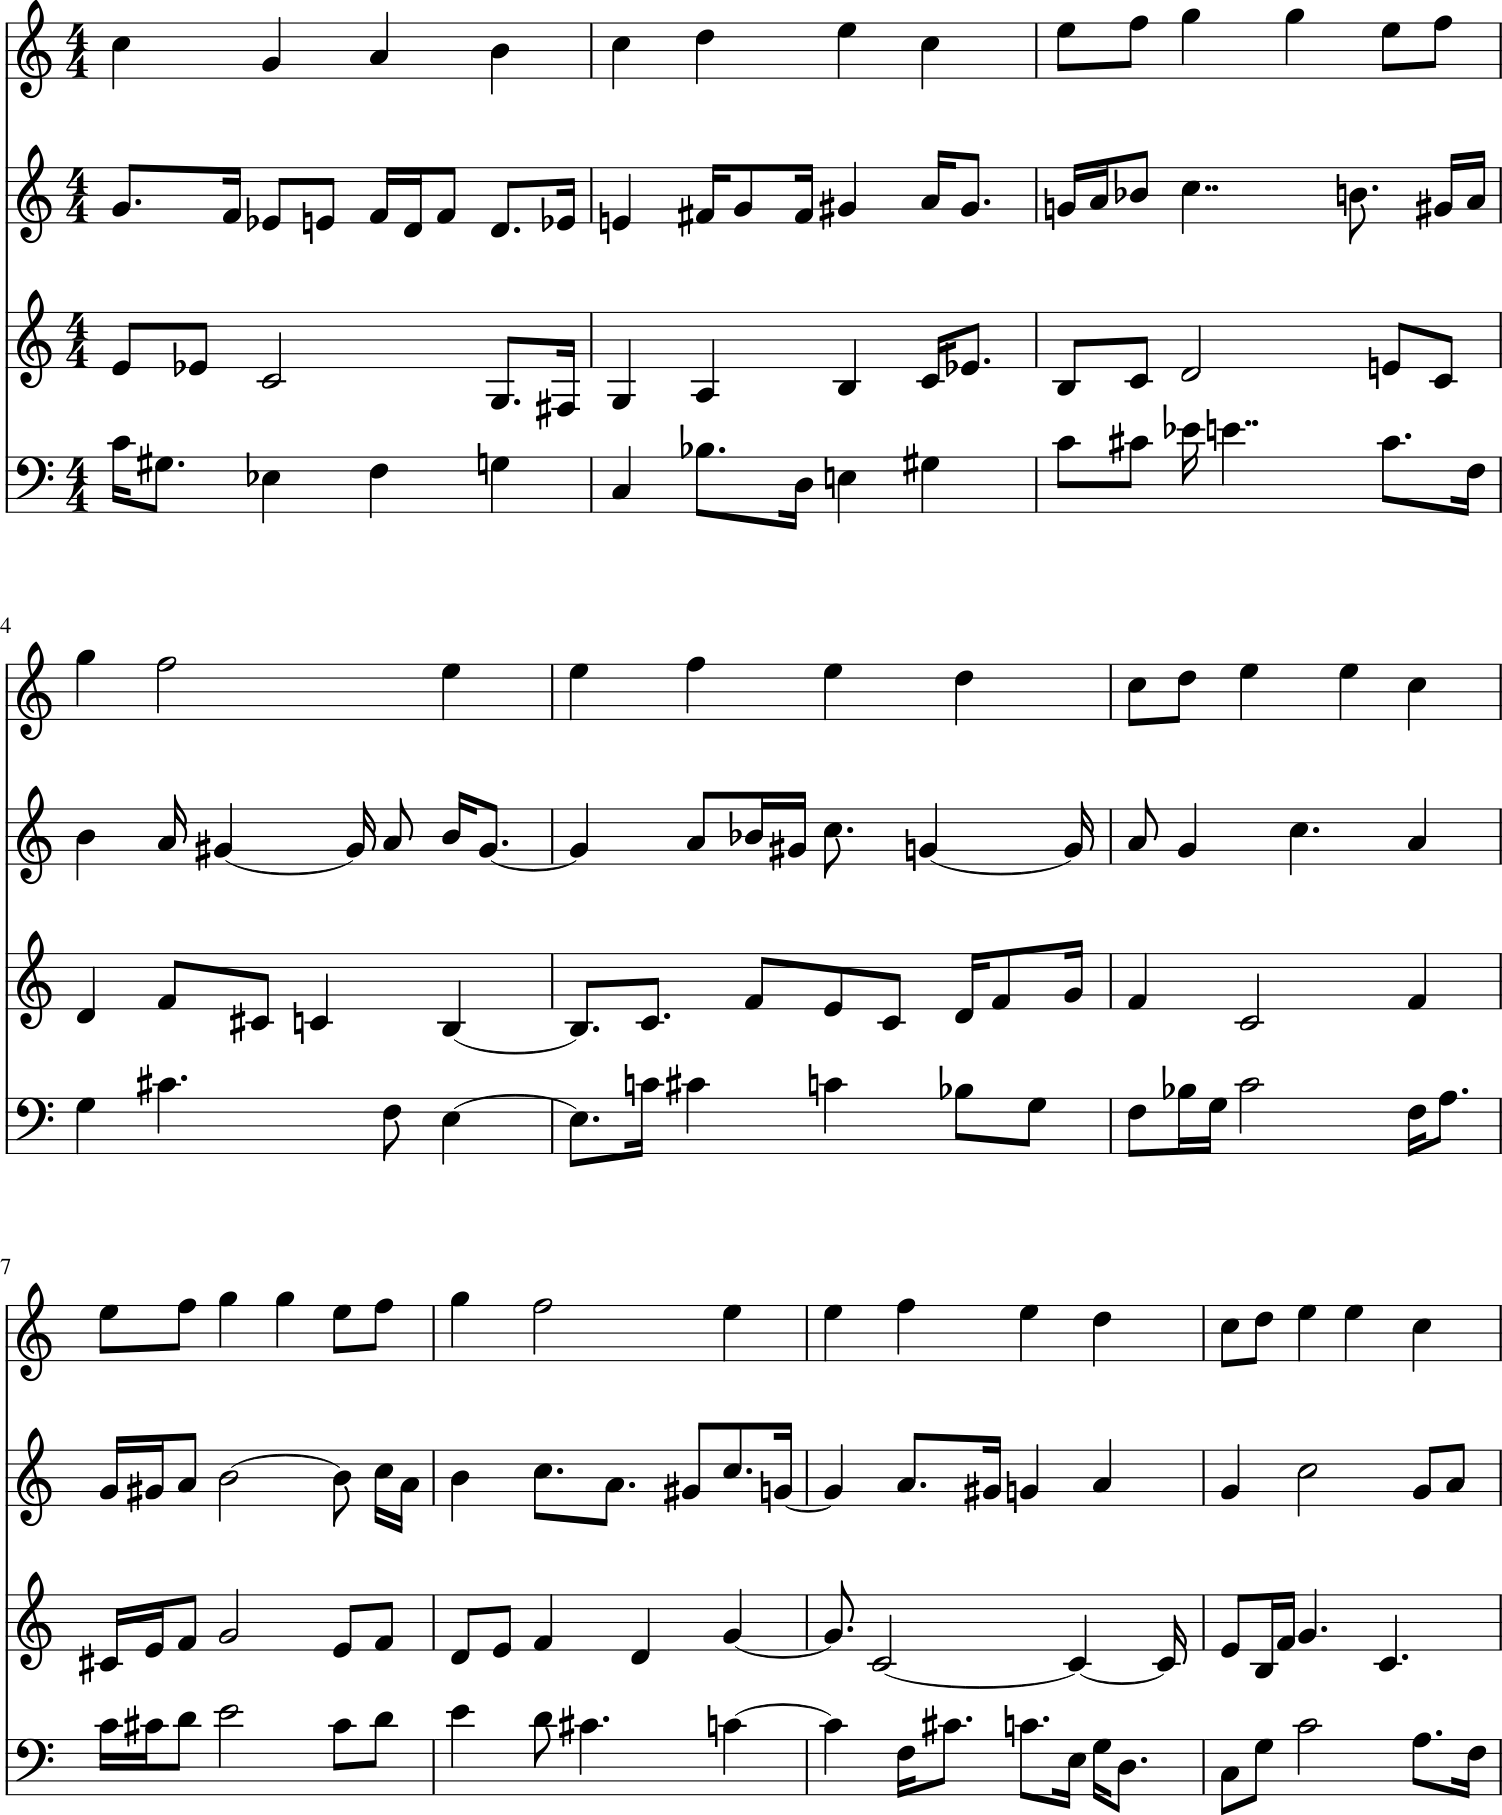

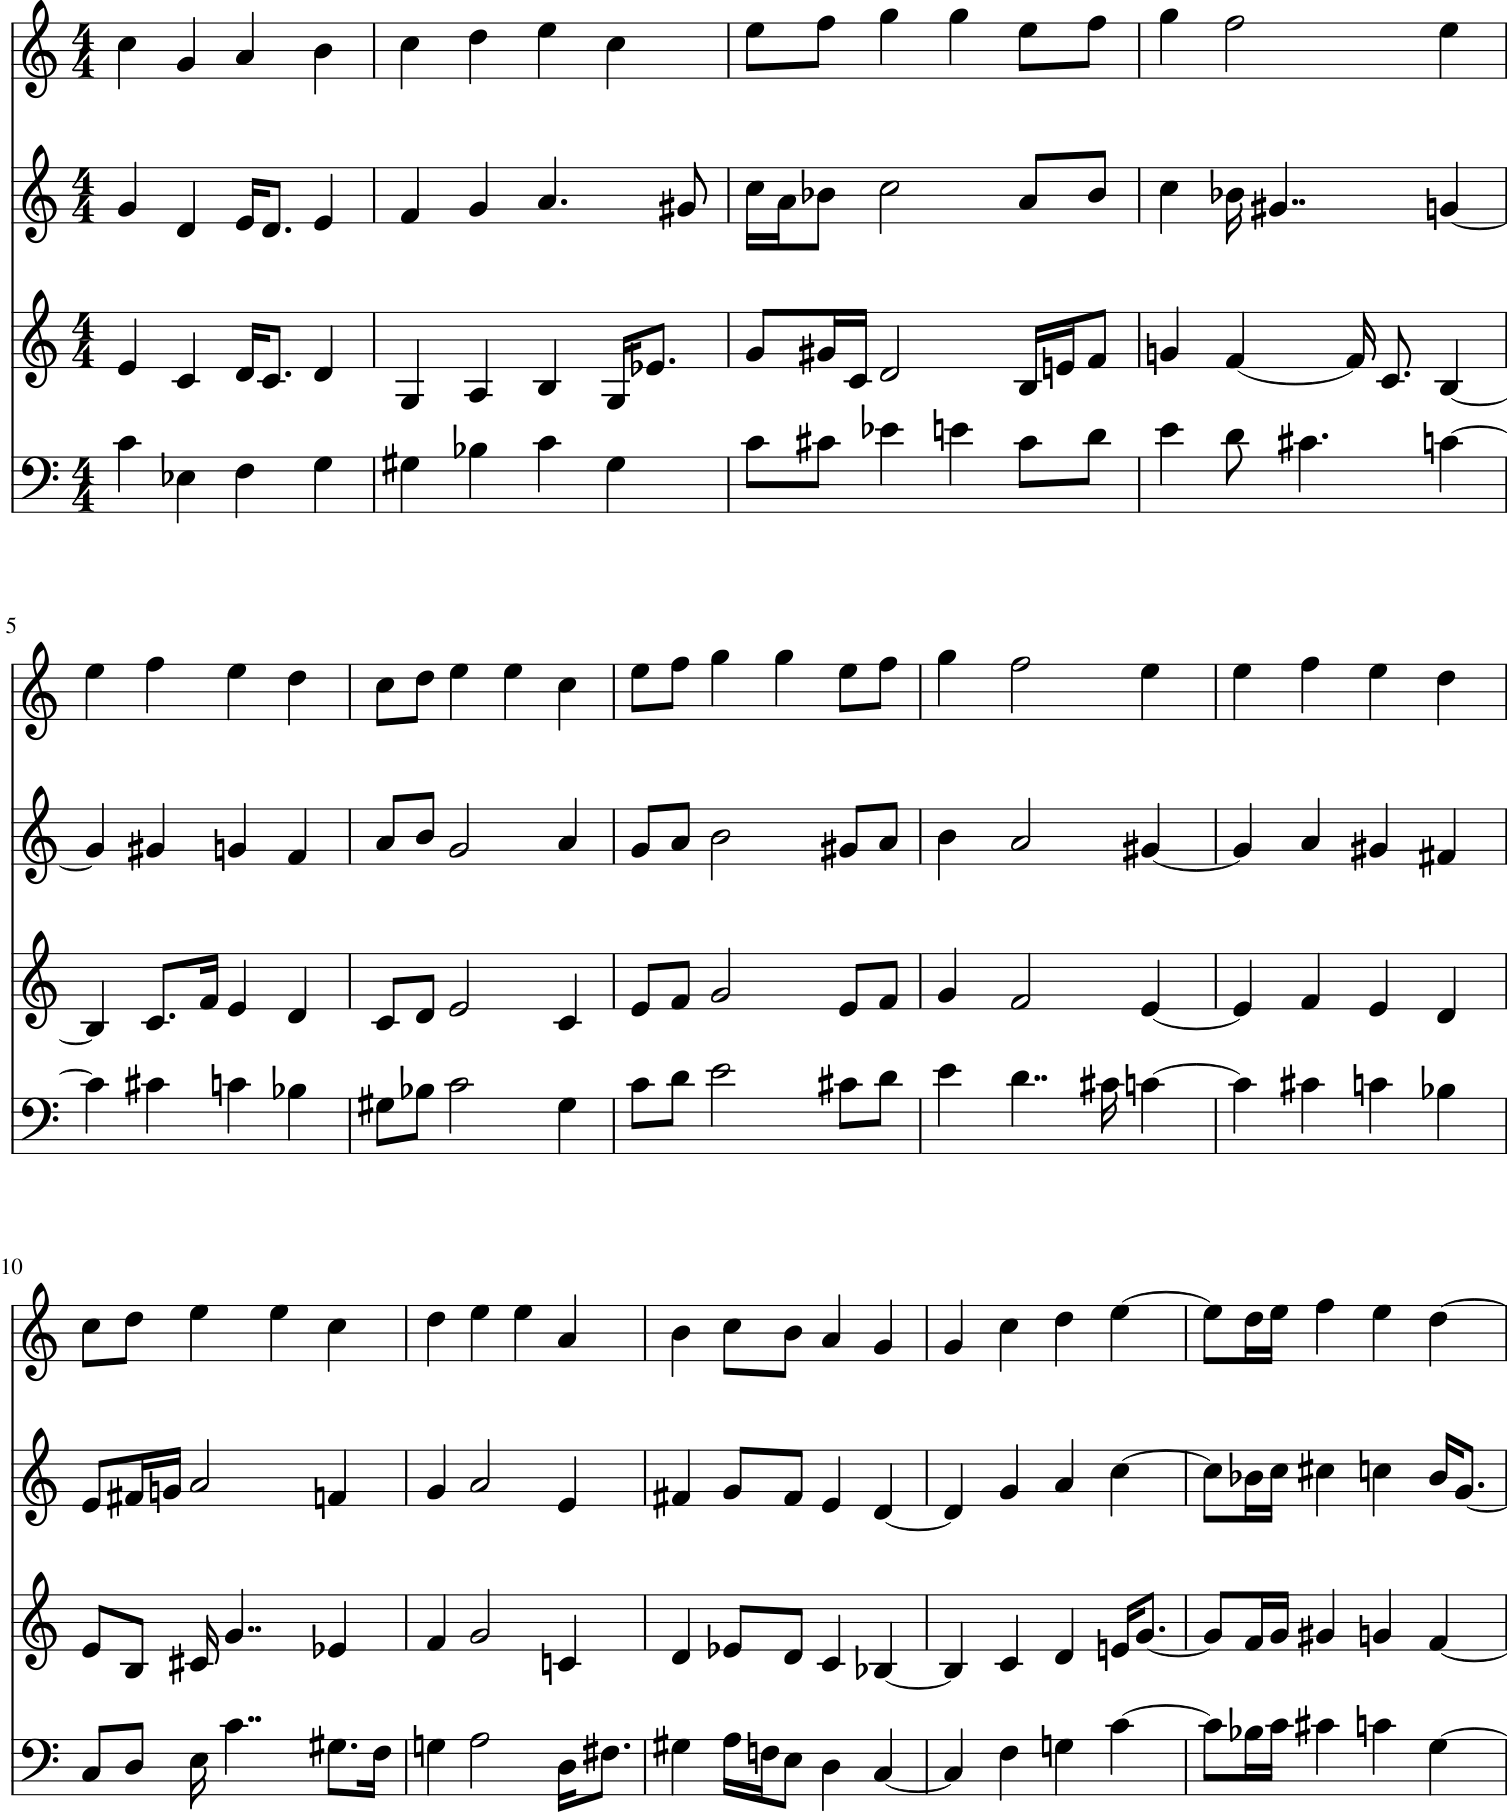

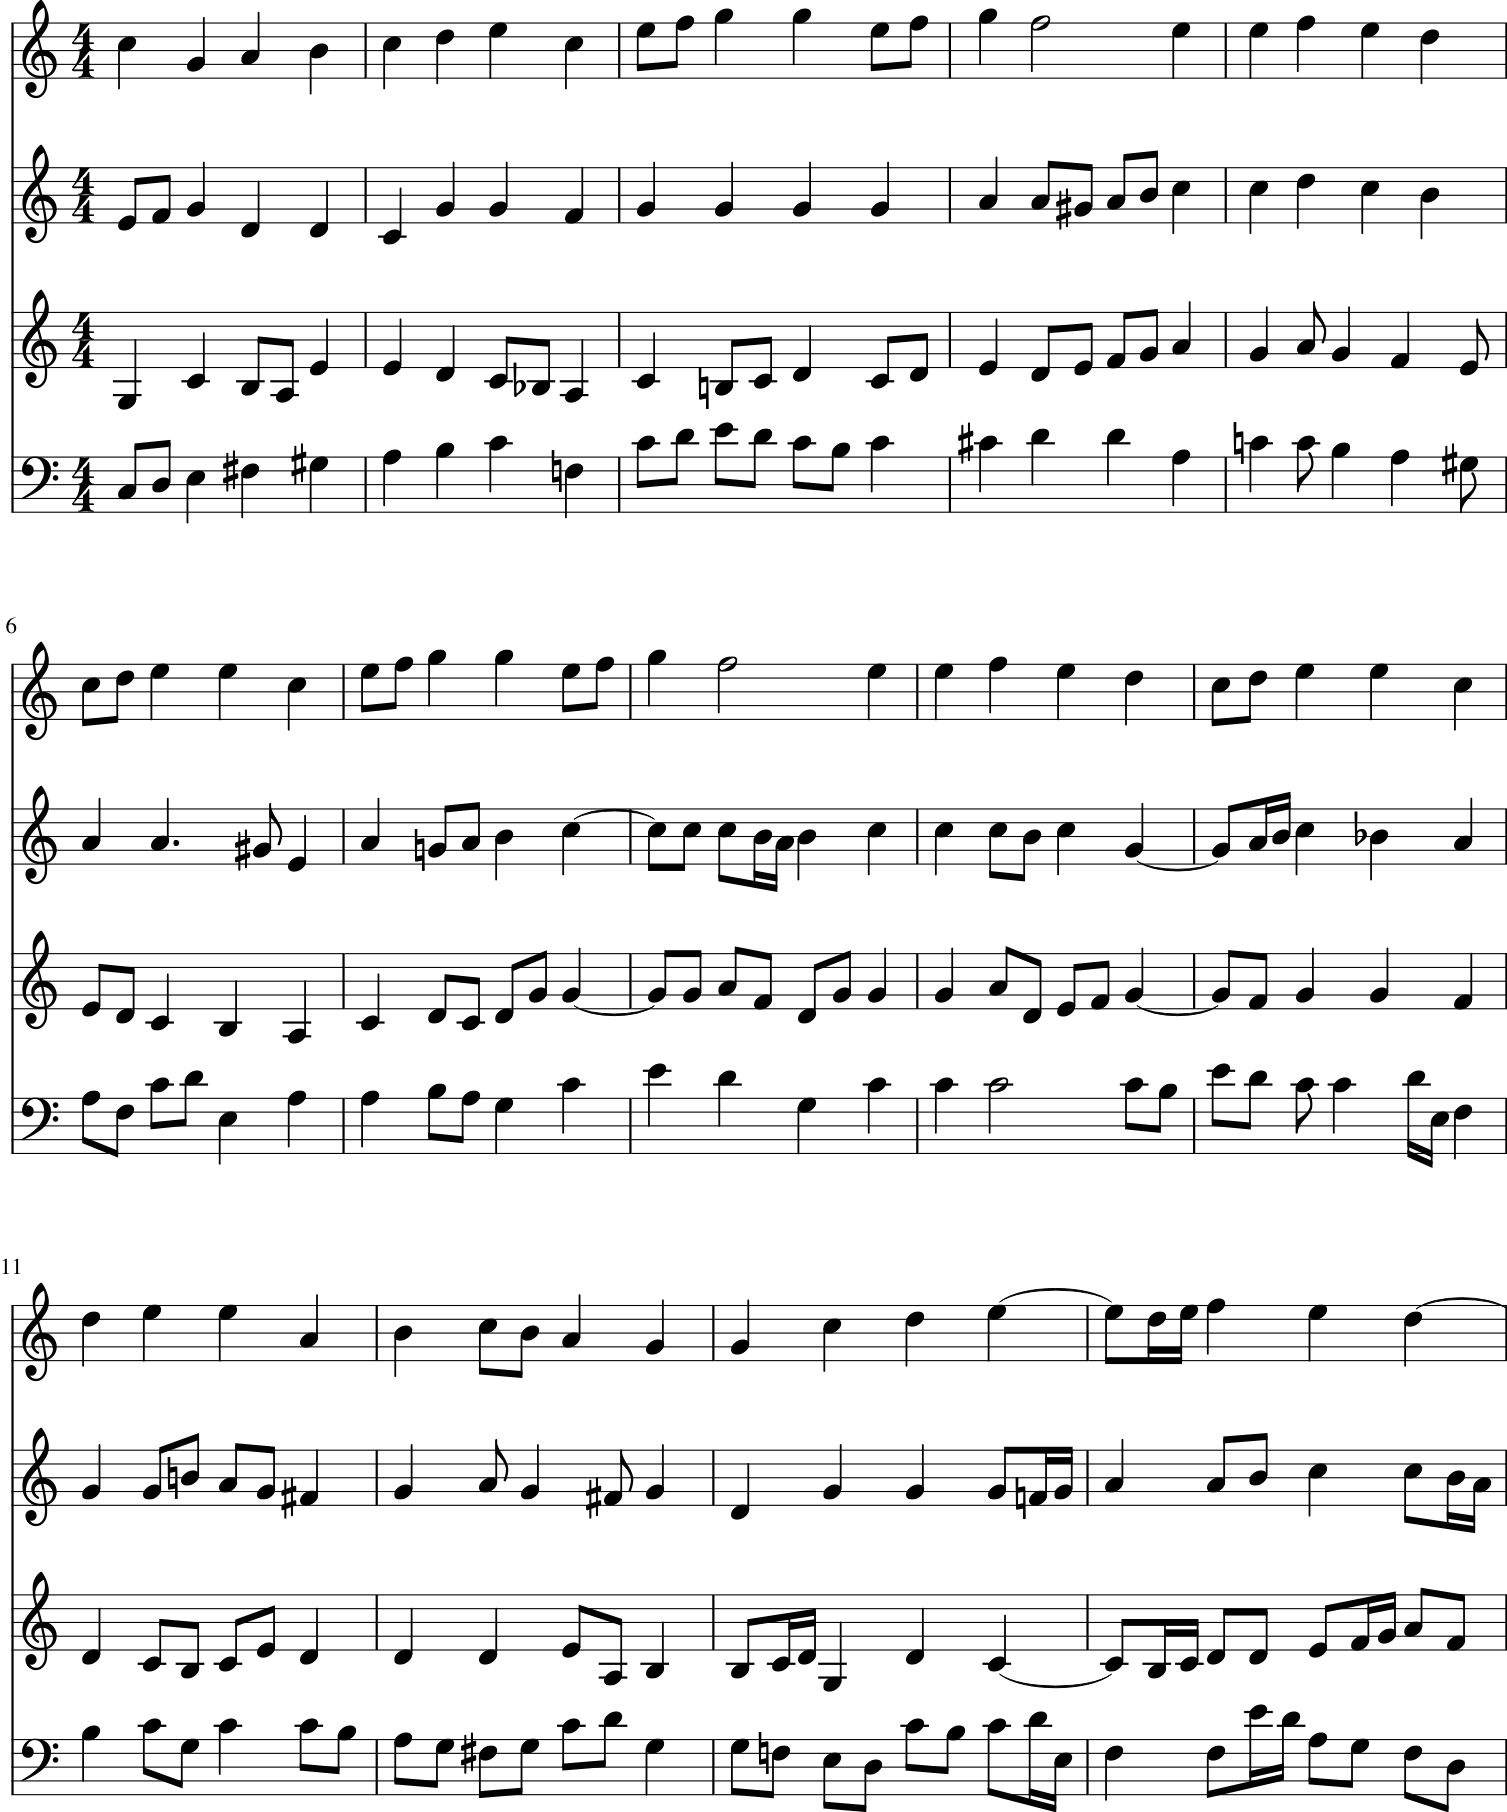

In [70]:
songNum = 92
sc = createStream(predSongs[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')

sc = createStream(predSongsSmooth[songNum], 4)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')


sc = createStream(songs[songNum], 4)
sc.show()
sc.show('midi')



In [16]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/98songs2voice4_4Peep')

'/home/lucky/models/98songs2voice4_4Peep'

In [26]:
print(len(songs))

98
